# Calculating charges of one molecule with a temporary server


In this tutorial, we calculate the RESP charges of one molecule with a temporary server.

In [1]:
import psiresp

## Creating the molecule

Let's choose a small molecule (DMSO) at a
low level of theory so that computations finish in a manageable
amount of time. I will use the RDKit 
package to create the molecule from SMILES. 

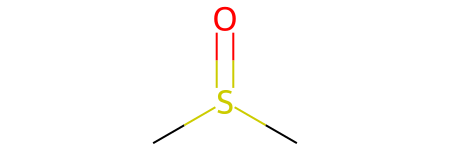

In [2]:
from rdkit import Chem
rd_dmso = Chem.MolFromSmiles("CS(=O)C")
rd_dmso

Below we set up a PsiRESP molecule. Nothing is executed when we first create it; the `optimize_geometry` flag simply tells a `Job` whether or not to optimize conformers. Note that no conformers are present when the molecule is first created.

In [3]:
dmso = psiresp.Molecule.from_rdkit(rd_dmso, optimize_geometry=True)
print(dmso.conformers)

[]


As only a SMILES string was given as input, a random conformer was generated for the QCElemental molecule. 

In [4]:
dmso.qcmol

NGLWidget()

A picture is provided below if the NGLView widget does not appear.

![dmso](images/dmso.png)

## Setting up a server

As this tutorial is written and running in a Jupyter notebook, we will use QCFractal's `FractalSnowflakeHandler` as a server. For Python scripts, it is recommended to use `psiresp.testing.FractalSnowflake` instead, a patch of QCFractal's `FractalSnowflake`; and on HPC computing clusters, to use QCFractal's `FractalServer`.

In [5]:
from qcfractal import FractalSnowflakeHandler

server = FractalSnowflakeHandler()
print(server)

FractalSnowflakeHandler(name='db_e2f8b1ef_87d0_4b80_9dd1_d811a05f221b' uri='https://localhost:55650')


We need to create a client to talk to the server.

In [6]:
client = server.client()
print(client)

FractalClient(server_name='FractalSnowFlake_db_e2f8b', address='https://localhost:55650/', username='None')


## Setting up the job

Let's first set up some job options. The typical method and basis set for QM computation are "hg/6-31g*", but we go with "b3lyp/sto-3g" here to save time.

In [7]:
geometry_options = psiresp.QMGeometryOptimizationOptions(
    method="b3lyp", basis="sto-3g")
esp_options = psiresp.QMEnergyOptions(
    method="b3lyp", basis="sto-3g",
)

Below are the full keywords that can be customised:

In [8]:
geometry_options

QMGeometryOptimizationOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='gradient', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, g_convergence='gau_tight', max_iter=200, full_hess_every=10, jobname='optimization')

In [9]:
esp_options

QMEnergyOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='energy', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, jobname='single_point')

`pcm_options` controls solvation options, should you wish to run the QM computations in solvent. The default options look like:

In [10]:
psiresp.qm.PCMOptions()

PCMOptions(medium_solver_type='CPCM', medium_solvent='water', cavity_radii_set='Bondi', cavity_type='GePol', cavity_scaling=True, cavity_area=0.3, cavity_mode='Implicit')

Note that these are easily transferrable as JSON objects:

In [11]:
geometry_options.json()

'{"method": "b3lyp", "basis": "sto-3g", "pcm_options": null, "driver": "gradient", "query_interval": 20, "protocols": {"wavefunction": "orbitals_and_eigenvalues"}, "g_convergence": "gau_tight", "max_iter": 200, "full_hess_every": 10, "jobname": "optimization"}'

The default RESP options in PsiRESP make for what can be considered
canonical RESP: a 2-stage restrained fit, where hydrogens are
excluded from the restraint, and the scale factors for the asymptote
limits of the hyperbola restraint are 0.0005 and 0.001 for the first
and second stage respectively.

Let's have a look at everything we can characterize.

In [12]:
resp_options = psiresp.RespOptions()
resp_options

RespOptions(resp_b=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, resp_a1=0.0005, resp_a2=0.001, stage_2=True)

Now let's create a PsiRESP job. If we inspect all the possible options, you can see that you can specify grid options (to create the grid for which the ESP is evaluated), and charge constraint options (for setting charge restraints). We will leave these as defaults for now.

In [13]:
job = psiresp.Job(molecules=[dmso],
                qm_optimization_options=geometry_options,
                qm_esp_options=esp_options,
                resp_options=resp_options)
job

Job(molecules=[Molecule(name=C2H6OS, charge=0) with 0 conformers], qm_optimization_options=QMGeometryOptimizationOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='gradient', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, g_convergence='gau_tight', max_iter=200, full_hess_every=10, jobname='optimization'), qm_esp_options=QMEnergyOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='energy', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, jobname='single_point'), grid_options=GridOptions(grid_rmin=0, grid_rmax=-1, use_radii='msk', vdw_radii={}, vdw_scale_factors=[1.4, 1.6, 1.8, 2.0], vdw_point_density=1.0), resp_options=RespOptions(resp_b=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, resp_a1=0.0005, resp_a2=0.001, stage_2=True), charge_constraints=ChargeConstraintOptions(charge_sum_constraints=[], charge_equivalence_constraints=[], symmetric_methyls=True, symm

## Running the job

Now let's run the job. This might take some time, as it requires optimizing geometries and computing single points, all on your device. If you do not pass a client, the job will instead write Psi4 job files, and exit.

In [14]:
job.run(client=client)
print(job.charges)

compute-esp: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.34it/s]


[array([-0.2667550084229739,  0.285266214850892 , -0.29331658435401  ,
       -0.2573715346042459,  0.0933276521930624,  0.0780997036181001,
        0.0980593319251959,  0.076496329626605 ,  0.0886511347035256,
        0.0975427604638489])]


After running the job, you can inspect the charges more closely at `job.stage_1_charges` and (optionally) `job.stage_2_charges`. Each of these are also JSON-serializable objects, so you can save them with the associated parameters, charge constraints, molecules, and ESP surface constraints used to generate the final output charges.

In [15]:
job.stage_1_charges

<RespCharges(resp_a=0.0005, resp_b=0.1, restrained_fit=True, exclude_hydrogens=True) with 0 charge constraints; unrestrained_charges=[array([-0.3678205325257203,  0.3226202044855306, -0.2953655242848086,
       -0.3650854903224527,  0.1197831149074085,  0.1067080977145354,
        0.1271095896803758,  0.1061240491319365,  0.1170412953648885,
        0.1288851958483063])], restrained_charges=[array([-0.2667550084229739,  0.285266214850892 , -0.2933165843540099,
       -0.2573715346042461,  0.0933276521930625,  0.0780997036181002,
        0.0980593319251957,  0.076496329626605 ,  0.0886511347035256,
        0.0975427604638489])]>

The optimized geometries and orientation coordinates can also be found when inspecting the job molecules. For example, here is the optimized DMSO:

In [16]:
job.molecules[0].conformers[0].qcmol

NGLWidget()

And the orientations:

In [17]:
job.molecules[0].conformers[0].orientations[0].qcmol

NGLWidget()

It's highly recommended to serialise the job after running it for easy inspection of everything involved in the job. For example, with:

```
with open('my_job.json', 'w') as f:
    f.write(job.json())
```

In [19]:
job.json()

'{"molecules": [{"qcmol": {"schema_name": "qcschema_molecule", "schema_version": 2, "validated": true, "symbols": ["C", "S", "O", "C", "H", "H", "H", "H", "H", "H"], "geometry": [[-0.92574415, 3.37830816, 1.74035389], [1.6435124, 2.2317028, 3.6146067], [1.29940739, 3.00207035, 6.35344167], [1.92566433, -1.13842039, 3.2734644], [-1.01584802, 5.45444911, 1.82249241], [-0.61107954, 2.84340583, -0.24288924], [-2.67977135, 2.44801908, 2.36038128], [0.28093643, -1.96465947, 2.23532331], [3.73943319, -1.56108622, 2.28290806], [1.98893355, -1.96100385, 5.21792674]], "name": "C2H6OS", "molecular_charge": 0.0, "molecular_multiplicity": 1, "connectivity": [[0, 1, 1.0], [0, 4, 1.0], [0, 5, 1.0], [0, 6, 1.0], [1, 2, 2.0], [1, 3, 1.0], [3, 7, 1.0], [3, 8, 1.0], [3, 9, 1.0]], "fix_com": false, "fix_orientation": false, "provenance": {"creator": "QCElemental", "version": "v0.22.0", "routine": "qcelemental.molparse.from_schema"}, "extras": {"canonical_isomeric_explicit_hydrogen_mapped_smiles": "[H]-[C: